In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [3]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [4]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [5]:
# load all the possible
n_options = 156
all_k1 = np.zeros((n_options))
all_k2 = np.zeros((n_options))
all_filters = np.zeros((n_options))
all_removeAvg = np.zeros((n_options))
all_masks = np.zeros((n_options))
with open('array_combinations_fmriprep2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #print(row)
        if line_count > 0:
            i=np.int(row[0])
            all_k1[i-1]=np.int(row[1])
            all_k2[i-1]=np.int(row[2])
            all_filters[i-1]=np.int(row[3])
            all_removeAvg[i-1]=np.int(row[4])
            all_masks[i-1]=np.int(row[5])
        line_count += 1

In [6]:
# now see how many have finished if exists, ploy
iterations_completed = []
classifierType = 1
lowhigh = 0
boostrapped = 1 # whether or not to randomly sample training data w/ replacement

for ii in np.arange(n_options):
    perm = ii + 1
    index = ii
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    ROI = np.int(all_masks[index])
    removeAvg = np.int(all_removeAvg[index])
    if not boostrapped:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
    else:
        filename_data = 'new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'

    #print(filename_data)
    if os.path.isfile(filename_data):
        print('ITERATION %i FOUND' % perm)
        iterations_completed.append(ii)
        all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    else:
        print('ITERATION %i NOT FOUND' % perm)
print('*************************************************')
print('ITERATIONS COMPLETED:')
print(iterations_completed)
n_completed = len(iterations_completed)
print('number completed: %i/%i' % (n_completed,n_options))

ITERATION 1 FOUND
ITERATION 2 FOUND
ITERATION 3 FOUND
ITERATION 4 FOUND
ITERATION 5 FOUND
ITERATION 6 FOUND
ITERATION 7 FOUND
ITERATION 8 FOUND
ITERATION 9 FOUND
ITERATION 10 FOUND
ITERATION 11 FOUND
ITERATION 12 FOUND
ITERATION 13 FOUND
ITERATION 14 FOUND
ITERATION 15 FOUND
ITERATION 16 FOUND
ITERATION 17 FOUND
ITERATION 18 FOUND
ITERATION 19 FOUND
ITERATION 20 FOUND
ITERATION 21 FOUND
ITERATION 22 FOUND
ITERATION 23 FOUND
ITERATION 24 FOUND
ITERATION 25 FOUND
ITERATION 26 FOUND
ITERATION 27 FOUND
ITERATION 28 FOUND
ITERATION 29 FOUND
ITERATION 30 FOUND
ITERATION 31 FOUND
ITERATION 32 FOUND
ITERATION 33 FOUND
ITERATION 34 FOUND
ITERATION 35 FOUND
ITERATION 36 FOUND
ITERATION 37 FOUND
ITERATION 38 FOUND
ITERATION 39 FOUND
ITERATION 40 FOUND
ITERATION 41 FOUND
ITERATION 42 FOUND
ITERATION 43 FOUND
ITERATION 44 FOUND
ITERATION 45 FOUND
ITERATION 46 FOUND
ITERATION 47 FOUND
ITERATION 48 FOUND
ITERATION 49 FOUND
ITERATION 50 FOUND
ITERATION 51 FOUND
ITERATION 52 FOUND
ITERATION 53 FOUND
IT

In [7]:
# find the winning/top versions
# now for the ones that have been completed:
# 1. average accuracy over 1000 samples
# 2. average accuracy over all TRs
# 3. plot
# 4. determine which one has the best one
n_completed = len(iterations_completed)
nTR = 450
n_iter = 1000
all_accuracy_data = np.zeros((nTR,n_iter,n_completed))
for cc in np.arange(n_completed):
    perm = iterations_completed[cc] + 1
    index = perm - 1
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    ROI = np.int(all_masks[index])
    removeAvg = np.int(all_removeAvg[index])
    if not boostrapped:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
    else:
        filename_data = 'new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'

    all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    all_accuracy_data[:,:,cc] = all_accuracies

# all_accuracy_data is 450 TRs x 1000 iterations x number of types completed
TR_average = np.mean(all_accuracy_data,axis=1)
# now plot mean over all TRs in order from best to worst
total_average = np.mean(TR_average,axis=0)
large_small_ind = np.argsort(total_average)[::-1] # this is the indexes form all the ones that have been completed
TR_average_sorted = TR_average[:,large_small_ind]
total_average_sorted = total_average[large_small_ind]
print('the best classification accuracy is %4.4f' % total_average_sorted[0])

#np.argwhere(iterations_completed == version)[0][0]
for ranking in np.arange(4):
    print('*******************************')
    print('RANK %i' % ranking )
    version = iterations_completed[large_small_ind[ranking]]
    print('AVERAGE ACCURACY = %4.4f' % total_average_sorted[ranking])
    print('mask')
    print(all_masks[version])
    print('avg removed')
    print(all_removeAvg[version])
    print('filter')
    print(all_filters[version])
    print('k1,k2')
    print(all_k1[version])
    print(all_k2[version])
    #print(all_k1[large_small_ind])

the best classification accuracy is 0.5555
*******************************
RANK 0
AVERAGE ACCURACY = 0.5555
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
25.0
*******************************
RANK 1
AVERAGE ACCURACY = 0.5504
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
100.0
*******************************
RANK 2
AVERAGE ACCURACY = 0.5499
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
50.0
*******************************
RANK 3
AVERAGE ACCURACY = 0.5497
mask
1.0
avg removed
0.0
filter
0.0
k1,k2
0.0
25.0


In [18]:
# load the specified winning combination
classifierType = 1

ROI = 1
removeAvg = 1
filterType = 1
k1 = 0
k2 = 25

if not boostrapped:
    filename_data = glob.glob('new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
else:
    filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)

0.5330888888888888

(447,)
(1000, 447)


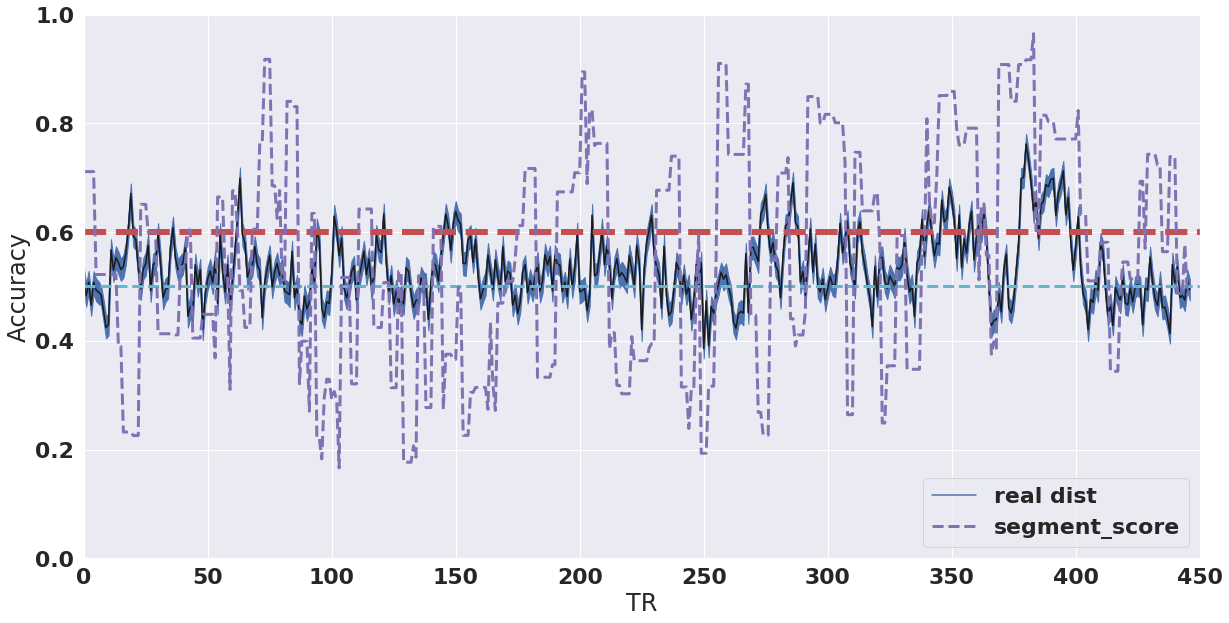

REAL correlation is 0.1687
REAL p value is 0.0003


Text(0,0.5,'Zscored segment difference')

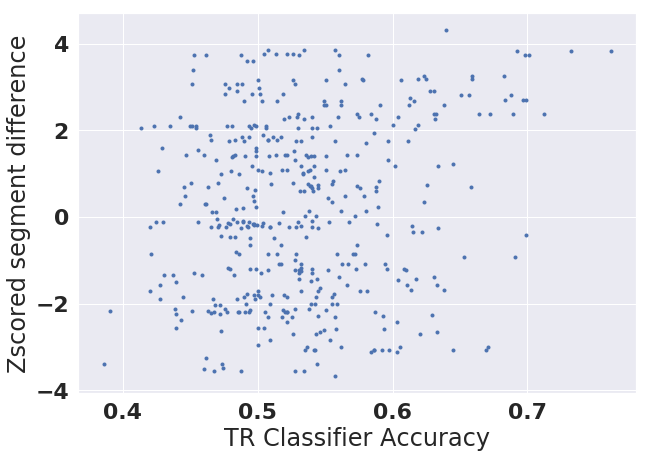

In [9]:
x = np.arange(nTR-3)
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)

print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1

plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')

plt.plot(x,np.mean(y,axis=0), color='k')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlim([0,nTR])

plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)
plt.plot()
plt.legend(loc=4)
plt.ylabel('Accuracy')
plt.show()
[corr,p] = scipy.stats.pearsonr(mean_acc,segment_score_vector[0:-3])
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %4.4f' % p)

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

Text(0,0.5,'Zscored segment difference')

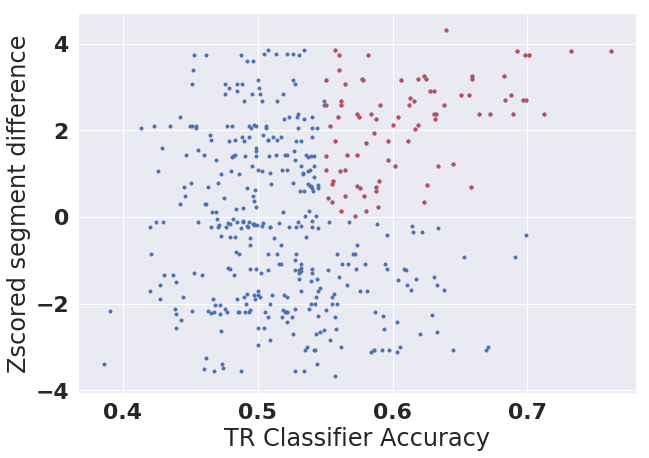

In [10]:
seg_shifted = segment_score_vector[0:-3]
TR_vector = np.arange(len(seg_shifted))
large_diff = seg_shifted > 0
large_acc = mean_acc > 0.55
upper_right = np.intersect1d(TR_vector[large_diff],TR_vector[large_acc])

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.plot(mean_acc[upper_right],seg_shifted[upper_right], 'r.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

In [11]:
TR_vector[large_acc]
# lets add to the upper_right vector: time points w/ high accuracy and large story differences right before
points_to_add = np.arange(144,153)
print(points_to_add)
new_upper_right = np.sort(np.concatenate((upper_right,points_to_add),axis=0))
new_upper_right

[144 145 146 147 148 149 150 151 152]


array([ 26,  41,  55,  61,  62,  69,  75,  84, 113, 115, 144, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 196, 199, 205, 208, 209, 211,
       234, 267, 277, 278, 282, 283, 284, 292, 293, 295, 305, 306, 307,
       312, 313, 314, 321, 331, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 357, 358, 360,
       362, 363, 364, 372, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       400, 401, 410, 411, 430])

In [17]:
TR_vector[large_acc]

array([ 11,  13,  17,  18,  19,  20,  21,  26,  30,  35,  36,  37,  41,
        55,  61,  62,  63,  64,  65,  69,  75,  84,  94,  95, 101, 102,
       103, 104, 113, 115, 118, 119, 120, 121, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 155, 156, 158, 163, 169, 186, 188, 190, 196,
       199, 205, 208, 209, 211, 215, 220, 223, 227, 228, 229, 230, 234,
       267, 269, 270, 271, 273, 274, 275, 276, 277, 278, 282, 283, 284,
       285, 286, 287, 288, 292, 293, 295, 305, 306, 307, 308, 312, 313,
       314, 321, 322, 331, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 357, 358, 360,
       361, 362, 363, 364, 372, 377, 378, 379, 380, 381, 382, 383, 384,
       385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
       398, 400, 401, 410, 411, 430])

[ 64  65 147 148 149 150 151 152 153 154 155 211 212 280 281 285 286 287
 295 296 308 309 310 315 316 317 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 358 359 360 361 365 366 367 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 403
 404 413 414]


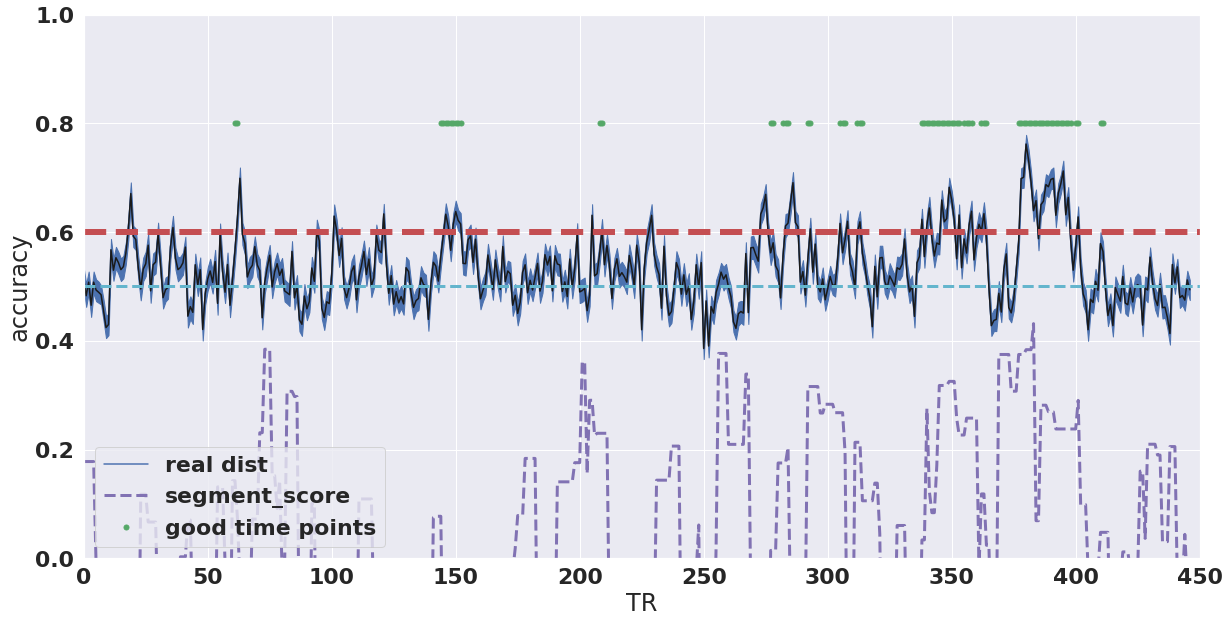

In [13]:
differences = np.diff(new_upper_right)
good_diff = np.argwhere(differences==1)
good_time_points = []
for i in np.arange(len(good_diff)):
    this_diff = good_diff[i][0]
    good_time_points.append(new_upper_right[this_diff])
    good_time_points.append(new_upper_right[this_diff+1])
final_good = np.unique(good_time_points)

vector_TR = -1*np.ones((len(mean_acc),))
vector_TR[final_good] = 0.8
plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + 0, '--', color='m', label='segment_score',linewidth=3)
plt.plot(x,np.mean(y,axis=0), color='k')
plt.plot(np.arange(len(mean_acc)),vector_TR,'g.', label='good time points', markersize=10)
plt.legend(loc=3)

#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlim([0,nTR])

print(final_good+3)
shifted_back = final_good+3
#np.save('final_good_pts.npy',shifted_back) #so this is actual TR number

In [15]:
shifted_back

array([ 64,  65, 147, 148, 149, 150, 151, 152, 153, 154, 155, 211, 212,
       280, 281, 285, 286, 287, 295, 296, 308, 309, 310, 315, 316, 317,
       341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354, 355, 356, 358, 359, 360, 361, 365, 366, 367, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 403, 404, 413, 414])

In [16]:
# now build dictionary list
station_dict = {}
station_dict[0] = [64,65]
station_dict[1] = [147, 148, 149, 150, 151, 152, 153, 154, 155]
station_dict[2] = [211, 212]
station_dict[3] = [280, 281, 282, 283, 284 285, 286, 287]
station_dict[4] = [295, 296]
station_dict[5] = [308, 309, 310, 311,312,313,314,315, 316, 317]
station_dict[6] = [341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,354, 355, 356, 358, 359, 360, 361,362,363,364,365, 366, 367]
station_dict[7] = [380, 381, 382,383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,396, 397, 398, 399, 400, 401, 403, 404]
station_dict[8] = [413, 414]



SyntaxError: invalid syntax (<ipython-input-16-3579847b01b4>, line 6)

In [15]:
np.unique(good_time_points) + 3

array([ 64,  65, 147, 148, 149, 150, 151, 152, 153, 154, 155, 211, 212,
       280, 281, 285, 286, 287, 295, 296, 308, 309, 310, 315, 316, 317,
       341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354, 355, 356, 358, 359, 360, 361, 365, 366, 367, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 403, 404, 413, 414])

In [17]:
final_stations = np.unique(good_time_points)
shifted_final_stations = final_stations + 3
station_dict = {}
station_dict[0] = [64,65]
station_dict[1] = [72,73,74]
station_dict[2] = [87,88,89]
station_dict[3] = [116,117]
station_dict[4] = [179, 180, 181, 182, 183, 184, 185]
station_dict[5] = [194, 195, 196, 197, 198]
station_dict[6] = [235, 236, 237, 238]
station_dict[7] = [280, 281, 282, 283, 284, 285]
station_dict[8] = [346, 347, 348, 349, 350, 351, 352, 353, 354]
station_dict[9] = [360, 361, 362, 363]
station_dict[10] = [378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401]
station_dict[11] = [406, 407]
# why did i put these last two stations in??? they don't have high accuracy
station_dict[12] = [433, 434, 435, 436]
station_dict[13] = [438, 439]

np.save('stations_iter2.npy', station_dict)

In [18]:
stations = np.load('stations_iter2.npy')


In [16]:
station_dict

{0: [64, 65],
 1: [72, 73, 74],
 2: [87, 88, 89],
 3: [116, 117],
 4: [179, 180, 181, 182, 183, 184, 185],
 5: [194, 195, 196, 197, 198],
 6: [235, 236, 237, 238],
 7: [280, 281, 282, 283, 284, 285],
 8: [346, 347, 348, 349, 350, 351, 352, 353, 354],
 9: [360, 361, 362, 363],
 10: [378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401],
 11: [406, 407],
 12: [433, 434, 435, 436],
 13: [438, 439]}

In [17]:
np.save('stations_iter1.npy', station_dict)

In [26]:
z=np.load('stations_iter1.npy').item()

In [15]:
mean_acc[395:405]

array([0.7125, 0.632 , 0.664 , 0.584 , 0.53  , 0.574 , 0.628 , 0.534 ,
       0.4865, 0.4725])

[ 17  18  19  20  21  35  36  37  61  62  63  64  65  94  95 101 102 103
 104 118 119 120 121 144 145 146 147 148 149 150 151 152 155 156 208 209
 227 228 229 230 269 270 271 273 274 275 276 277 278 282 283 284 285 286
 287 288 292 293 305 306 307 308 312 313 314 321 322 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 355 356 357 358 360 361
 362 363 364 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 400 401 410 411]
[ 20  21  22  23  24  38  39  40  64  65  66  67  68  97  98 104 105 106
 107 121 122 123 124 147 148 149 150 151 152 153 154 155 158 159 211 212
 230 231 232 233 272 273 274 276 277 278 279 280 281 285 286 287 288 289
 290 291 295 296 308 309 310 311 315 316 317 324 325 340 341 342 343 344
 345 346 347 348 349 350 351 352 353 354 355 356 358 359 360 361 363 364
 365 366 367 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 403 404 413 414]


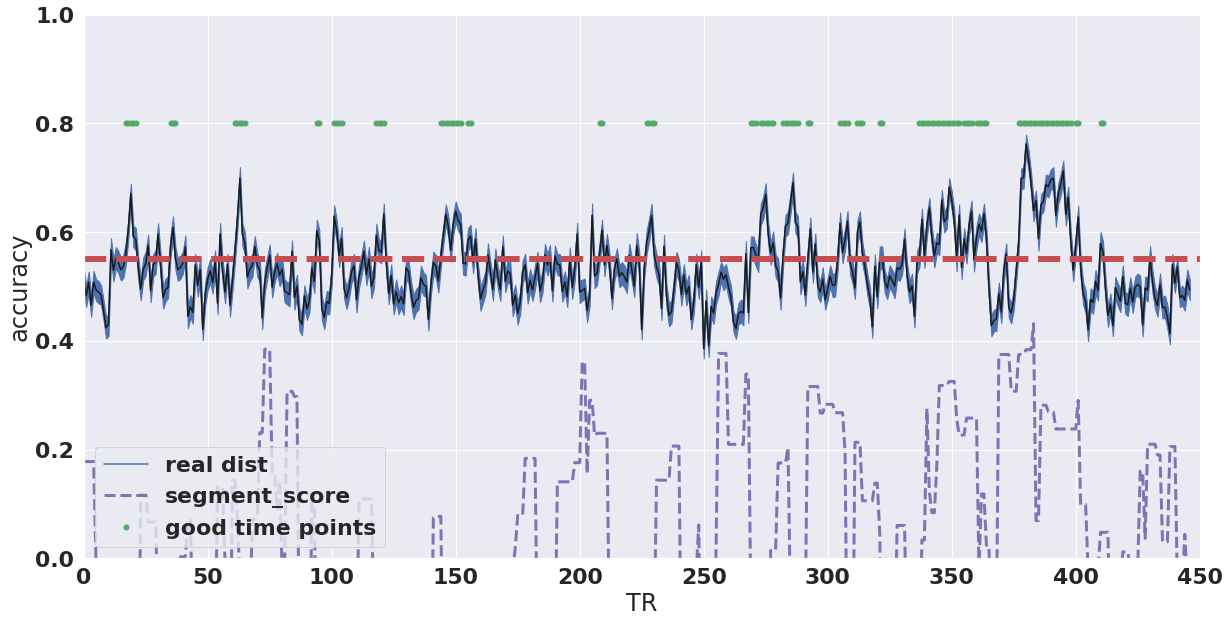

In [12]:
# new 3/8: see what the stations would be if you're only looking at accuracy above 55% and then consecutive points
high_accuracy = TR_vector[large_acc]
differences = np.diff(high_accuracy)
good_diff = np.argwhere(differences==1)
good_time_points = []
for i in np.arange(len(good_diff)):
    this_diff = good_diff[i][0]
    good_time_points.append(high_accuracy[this_diff])
    good_time_points.append(high_accuracy[this_diff+1])
final_good = np.unique(good_time_points)
print(final_good)

vector_TR = -1*np.ones((len(mean_acc),))
vector_TR[final_good] = 0.8
plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + 0, '--', color='m', label='segment_score',linewidth=3)
plt.plot(x,np.mean(y,axis=0), color='k')
plt.plot(np.arange(len(mean_acc)),vector_TR,'g.', label='good time points', markersize=10)
plt.legend(loc=3)

#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.55, .55], 'r--', lw=6)
plt.ylim([0,1])
plt.xlim([0,nTR])

shifted_back = final_good+3
print(shifted_back)

In [16]:
testing_stations_dict = {}
testing_stations_dict[0] = [20 , 21,  22 , 23 , 24]
testing_stations_dict[1] = [ 38 , 39 , 40]
testing_stations_dict[2] = [64 , 65  ,66 , 67,  68]
testing_stations_dict[3] = [ 97 , 98]
testing_stations_dict[4] = [104, 105, 106, 107]
testing_stations_dict[5] = [ 121, 122, 123 ,124 ]
testing_stations_dict[6] = [147, 148, 149, 150 ,151, 152 ,153 ,154 ,155]
testing_stations_dict[7] = [158, 159]
testing_stations_dict[8] = [211 ,212]
testing_stations_dict[9] = [230, 231, 232, 233]
testing_stations_dict[10] = [272 ,273, 274]
testing_stations_dict[11] = [ 276 ,277, 278 ,279 ,280, 281]
testing_stations_dict[12] = [285, 286, 287, 288 ,289, 290 ,291]
testing_stations_dict[13] = [ 295 ,296]
testing_stations_dict[14] = [308, 309 ,310 ,311]
testing_stations_dict[15] = [315 ,316 ,317]
testing_stations_dict[16] = [324, 325]
testing_stations_dict[17] = [340, 341, 342 ,343 ,344 ,345 ,346, 347, 348, 349 ,350 ,351, 352 ,353 ,354 ,355 ,356]
testing_stations_dict[18] = [358, 359 ,360 ,361]
testing_stations_dict[19] = [363, 364, 365 ,366, 367]
testing_stations_dict[20] = [380, 381, 382, 383, 384 ,385, 386, 387 ,388 ,389, 390, 391, 392 ,393, 394, 395 ,396 ,397, 398, 399, 400, 401]
testing_stations_dict[58] = [403 ,404]
testing_stations_dict[21] = [413,414]
# now let's make some shorter stations to see if we don't need the long versions
# let's say 5 TR = 7.5 second recording limit
testing_stations_dict[22] = [147, 148, 149, 150 ,151] # this way we could have enough time for the next station
testing_stations_dict[23] = [276 ,277, 278 ,279 ,280]
testing_stations_dict[24] = [285, 286, 287, 288 ,289]
testing_stations_dict[25] = [340, 341, 342 ,343 ,344 ]
testing_stations_dict[26] = [341, 342 ,343 ,344 ,345 ]
testing_stations_dict[27] = [342 ,343 ,344 ,345 ,346]
testing_stations_dict[28] = [343 ,344 ,345 ,346, 347]
testing_stations_dict[29] = [344 ,345 ,346, 347, 348]
testing_stations_dict[30] = [345 ,346, 347, 348, 349]
testing_stations_dict[31] = [346, 347, 348, 349 ,350]
testing_stations_dict[32] = [347, 348, 349 ,350 ,351]
testing_stations_dict[33] = [348, 349 ,350 ,351, 352]
testing_stations_dict[34] = [349 ,350 ,351, 352 ,353]
testing_stations_dict[35] = [350 ,351, 352 ,353 ,354]
testing_stations_dict[36] = [351, 352 ,353 ,354 ,355]
testing_stations_dict[37] = [352 ,353 ,354 ,355 ,356]
testing_stations_dict[38] = [380, 381, 382, 383, 384]
testing_stations_dict[39] = [381, 382, 383, 384 ,385]
testing_stations_dict[40] = [382, 383, 384 ,385, 386]
testing_stations_dict[41] = [383, 384 ,385, 386, 387]
testing_stations_dict[42] = [384 ,385, 386, 387 ,388]
testing_stations_dict[43] = [385, 386, 387 ,388 ,389]
testing_stations_dict[44] = [386, 387 ,388 ,389, 390]
testing_stations_dict[45] = [387 ,388 ,389, 390, 391]
testing_stations_dict[46] = [388 ,389, 390, 391, 392]
testing_stations_dict[47] = [389, 390, 391, 392 ,393]
testing_stations_dict[48] = [390, 391, 392 ,393, 394]
testing_stations_dict[49] = [391, 392 ,393, 394, 395]
testing_stations_dict[50] = [392 ,393, 394, 395 ,396]
testing_stations_dict[51] = [393, 394, 395 ,396 ,397]
testing_stations_dict[52] = [394, 395 ,396 ,397, 398]
testing_stations_dict[53] = [395 ,396 ,397, 398, 399]
testing_stations_dict[54] = [396 ,397, 398, 399, 400]
testing_stations_dict[55] = [397, 398, 399, 400, 401]
testing_stations_dict[56] = [398, 399, 400, 401, 403] # ignore bc not continuous
testing_stations_dict[57] = [399, 400, 401, 403 ,404] # ignore bc not continuous
np.save('mega_testing_stations2.npy', testing_stations_dict) # 3 is updated when realized station 20 left out TR

In [26]:
# now: get winning station indices

58